In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
from simulator import get_simulator
from simulate import simulate
from simulate import mpi_simulate

In [3]:
system = {
    'duration': 1, 
    'resolution': 0.001,
    'species': [
        ('P', 0), 
        ('N', 10000), 
    ],
    'reactions': [
        (
            'omega', 
            ((1, 'N'), ),
            ((2, 'N'), )
        ), 
        (
            'alpha', 
            ((1, 'N'), ),
            ((1, 'P'), )
        ), 
        (
            'beta', 
            ((1, 'P'), ),
            ((1, 'N'), )
        ), 
        (
            'mu_P', 
            ((1, 'P'), ), 
            ()
        ), 
        (
            'mu_N', 
            ((1, 'N'), ), 
            ()
        ), 
    ], 
    'variables': [
        ('omega', 1.0), 
        ('alpha', 1.0), 
        ('beta', 1.0), 
        ('mu_P', 1.0), 
        ('mu_N', 1.0), 
    ], 
    'functions': [], 
    'targets': [
        'time', 
        'P', 
        'N', 
    ],
}

In [4]:
%matplotlib inline
import pandas as pd
from collections import OrderedDict
from simulator import get_simulator
from simulate import simulate

In [5]:
run = get_simulator(system)

ext module version: gillespie_2 2
Compiling ./gillespie_2.pyx because it changed.
[1/1] Cythonizing ./gillespie_2.pyx
running clean
removing 'build/temp.linux-x86_64-3.7' (and everything under it)
removing 'build'
running build_ext
building 'gillespie_2' extension
creating build/temp.linux-x86_64-3.7
gcc -pthread -B /home/cogle/dev/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/cogle/dev/anaconda3/lib/python3.7/site-packages/numpy/core/include -I/home/cogle/dev/anaconda3/include/python3.7m -c ./gillespie_2.c -o build/temp.linux-x86_64-3.7/./gillespie_2.o
gcc -pthread -shared -B /home/cogle/dev/anaconda3/compiler_compat -L/home/cogle/dev/anaconda3/lib -Wl,-rpath=/home/cogle/dev/anaconda3/lib -Wl,--no-as-needed -Wl,--sysroot=/ build/temp.linux-x86_64-3.7/./gillespie_2.o -o /home/cogle/dev/gillespie_modular/.simulators/gillespie_2.cpython-37m-x86_64-linux-gnu.so


In [6]:
data = run(0, mu_P=0.1)

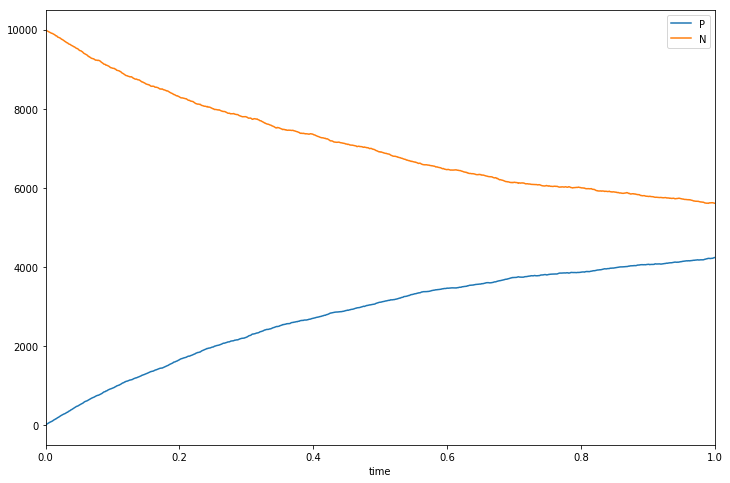

In [7]:
df = pd.DataFrame(OrderedDict((t, d) for t, d in zip(system['targets'], data)))
df.plot(x='time', kind='line', figsize=(12, 8))

In [8]:
from pscan import pscan_view

processing = ()

axes = (
    ('mu_P', (1.0, 0.1, 0.01, 0.001)),
)

#pspace, data = simulate(system, processing=processing, batchsize=10, axes=axes)
pspace, pscans = mpi_simulate(system, processing=processing, batchsize=1, axes=axes)

Scanning Parameters:   0%|          | 0/4 [00:00<?, ?it/s]

> start dispatch 0 ./.simulators/run.json
start dispatch 0 ./.simulators/run.json
> worker 2 start
worker 2 start
> setting up workers
setting up workers
> worker 6 start
worker 6 start
> worker 7 start
worker 7 start
> worker 3 start
worker 3 start
> worker 5 start
worker 5 start
> worker 4 start
worker 4 start
> worker 1 start
worker 1 start
> worker 1 setting up
worker 1 setting up
> ext module version: gillespie_2 2
ext module version: gillespie_2 2
> Compiling ./gillespie_2.pyx because it changed.
Compiling ./gillespie_2.pyx because it changed.
> [1/1] Cythonizing ./gillespie_2.pyx
[1/1] Cythonizing ./gillespie_2.pyx
> running clean
running clean
> removing 'build/temp.linux-x86_64-3.7' (and everything under it)
removing 'build/temp.linux-x86_64-3.7' (and everything under it)
> removing 'build'
removing 'build'
> running build_ext
running build_ext
> building 'gillespie_2' extension
building 'gillespie_2' extension
> creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x

Scanning Parameters:  25%|██▌       | 1/4 [00:07<00:22,  7.54s/it]

> worker 2 ran location 1
match worker 2 ran location 1
> worker 3 ran location 2
match worker 3 ran location 2
> worker 4 ran location 3
match worker 4 ran location 3
> saving output data...
saving output data...
> saved output data
saved output data
> end dispatch 0 ./.simulators/run.json
end dispatch 0 ./.simulators/run.json
> worker 4 halt
worker 4 halt
> worker 1 ran location 0
match worker 1 ran location 0
> worker 1 halt
worker 1 halt
> worker 6 halt
worker 6 halt
> worker 7 halt
worker 7 halt
> worker 5 halt
worker 5 halt
> worker 3 halt
worker 3 halt
> worker 2 halt
worker 2 halt


Scanning Parameters: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]

loading output data...
loaded output data


In [12]:
pspace

,mu_P
0,1.000
1,0.100
2,0.010
3,0.001


In [11]:
pscans

[array([[[0.000e+00, 1.000e-03, 2.000e-03, ..., 9.980e-01, 9.990e-01,
          1.000e+00],
         [0.000e+00, 3.000e+00, 1.200e+01, ..., 2.671e+03, 2.677e+03,
          2.677e+03],
         [1.000e+04, 9.985e+03, 9.972e+03, ..., 5.074e+03, 5.068e+03,
          5.065e+03]]]),
 array([[[0.000e+00, 1.000e-03, 2.000e-03, ..., 9.980e-01, 9.990e-01,
          1.000e+00],
         [0.000e+00, 1.000e+01, 2.500e+01, ..., 4.073e+03, 4.076e+03,
          4.070e+03],
         [1.000e+04, 9.983e+03, 9.971e+03, ..., 5.469e+03, 5.465e+03,
          5.471e+03]]]),
 array([[[0.000e+00, 1.000e-03, 2.000e-03, ..., 9.980e-01, 9.990e-01,
          1.000e+00],
         [0.000e+00, 1.200e+01, 1.900e+01, ..., 4.302e+03, 4.295e+03,
          4.299e+03],
         [1.000e+04, 9.988e+03, 9.981e+03, ..., 5.690e+03, 5.701e+03,
          5.701e+03]]]),
 array([[[0.000e+00, 1.000e-03, 2.000e-03, ..., 9.980e-01, 9.990e-01,
          1.000e+00],
         [0.000e+00, 1.000e+01, 2.000e+01, ..., 4.250e+03, 4.251e+03,
 